In [1]:
# import package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

import networkx as nx
from collections import deque

In [2]:
# df for flight planning
df = pd.read_csv('August 2018 Nationwide.csv')
df.head(3)

,FL_DATE,OP_CARRIER_AIRLINE_ID,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,...,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 28
0,2018-08-01,19805,N956AN,1587,12478,1247805,31703,JFK,14107,1410702,...,0.0,NaN,342.0,377.0,9.0,0.0,35.0,0.0,0.0,NaN
1,2018-08-01,19805,N973AN,1588,14107,1410702,30466,PHX,11618,1161802,...,0.0,NaN,285.0,309.0,0.0,0.0,53.0,0.0,0.0,NaN
2,2018-08-01,19805,N9006,1590,11042,1104205,30647,CLE,11298,1129806,...,0.0,NaN,176.0,177.0,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# drop nonnecessary column
df.drop(df.columns[-1], axis=1, inplace=True)

# copy df for use.
df_copy = df.copy()

# nonnecessary column list
drop_list = ['OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID',
       'ORIGIN_CITY_MARKET_ID', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'CANCELLATION_CODE']

for i in drop_list:
    df_copy = df_copy.drop(i, axis = 1)

# drop a cancelled flight
df_copy = df_copy.drop(df[df['CANCELLED'] != 0].index)

# fill in null values to zero.
df_copy = df_copy.fillna(0)

In [4]:
df_copy.head(3)

,FL_DATE,OP_CARRIER_AIRLINE_ID,TAIL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,CANCELLED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2018-08-01,19805,N956AN,JFK,PHX,1640,1649.0,9.0,9.0,2006.0,44.0,44.0,0.0,342.0,377.0,9.0,0.0,35.0,0.0,0.0
1,2018-08-01,19805,N973AN,PHX,EWR,1512,1541.0,29.0,29.0,2350.0,53.0,53.0,0.0,285.0,309.0,0.0,0.0,53.0,0.0,0.0
2,2018-08-01,19805,N9006,CLE,DFW,744,741.0,-3.0,0.0,938.0,-2.0,0.0,0.0,176.0,177.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# call csv. file latitude & longitude data
df_location = pd.read_csv('us_airports.csv')
df_location.head(3)

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,country_name,iso_country,...,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,score,last_updated
0,3632,KLAX,large_airport,Los Angeles International Airport,33.942501,-118.407997,125.0,NaN,United States,US,...,Los Angeles,1,KLAX,LAX,LAX,https://www.flylax.com/,https://en.wikipedia.org/wiki/Los_Angeles_Inte...,NaN,1335475,2020-04-26T22:37:22+00:00
1,3754,KORD,large_airport,Chicago O'Hare International Airport,41.978600,-87.904800,672.0,NaN,United States,US,...,Chicago,1,KORD,ORD,ORD,https://www.flychicago.com/ohare/home/pages/de...,https://en.wikipedia.org/wiki/O'Hare_Internati...,"CHI, Orchard Place",1503175,2018-09-16T02:35:35+00:00
2,3622,KJFK,large_airport,John F Kennedy International Airport,40.639801,-73.778900,13.0,NaN,United States,US,...,New York,1,KJFK,JFK,JFK,https://www.jfkairport.com/,https://en.wikipedia.org/wiki/John_F._Kennedy_...,"Manhattan, New York City, NYC, Idlewild, IDL, ...",1052075,2021-11-21T19:43:08+00:00


In [6]:
# extract only latitude data
latidf = df_location[['iata_code', 'latitude_deg']]
latidf.head(3)

,iata_code,latitude_deg
0,LAX,33.942501
1,ORD,41.978600
2,JFK,40.639801


In [7]:
# extract only longitude data
longidf = df_location[['iata_code', 'longitude_deg']]
longidf.head(3)

,iata_code,longitude_deg
0,LAX,-118.407997
1,ORD,-87.904800
2,JFK,-73.778900


In [8]:
# transform df to list
lati_diction =latidf.set_index('iata_code').T.to_dict('list')
longi_diction =longidf.set_index('iata_code').T.to_dict('list')

# add latitude & longitude columns by using map function.
df_copy['ORI_LATITUDE'] = df_copy['ORIGIN'].map(lati_diction)
df_copy['ORI_LONGITUDE'] = df_copy['ORIGIN'].map(longi_diction)
df_copy['DEST_LATITUDE'] = df_copy['DEST'].map(lati_diction)
df_copy['DEST_LONGITUDE'] = df_copy['DEST'].map(longi_diction)

df_copy.ORI_LATITUDE = df_copy.ORI_LATITUDE.str[0]
df_copy.ORI_LONGITUDE = df_copy.ORI_LONGITUDE.str[0]
df_copy.DEST_LATITUDE = df_copy.DEST_LATITUDE.str[0]
df_copy.DEST_LONGITUDE = df_copy.DEST_LONGITUDE.str[0]

In [9]:
# drop region no having latitude and longitude
df_copy = df_copy.drop(df_copy[df_copy['DEST_LATITUDE'].isnull() | df_copy['ORI_LATITUDE'].isnull()].index).reset_index(drop=True)
df_copy.head(3)

,FL_DATE,OP_CARRIER_AIRLINE_ID,TAIL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,ARR_TIME,...,ACTUAL_ELAPSED_TIME,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,ORI_LATITUDE,ORI_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE
0,2018-08-01,19805,N956AN,JFK,PHX,1640,1649.0,9.0,9.0,2006.0,...,377.0,9.0,0.0,35.0,0.0,0.0,40.639801,-73.778900,33.435302,-112.005905
1,2018-08-01,19805,N973AN,PHX,EWR,1512,1541.0,29.0,29.0,2350.0,...,309.0,0.0,0.0,53.0,0.0,0.0,33.435302,-112.005905,40.692501,-74.168701
2,2018-08-01,19805,N9006,CLE,DFW,744,741.0,-3.0,0.0,938.0,...,177.0,0.0,0.0,0.0,0.0,0.0,41.411701,-81.849800,32.896801,-97.038002


In [10]:
# make origin data
df_origin = df_copy[['ORIGIN', 'ORI_LATITUDE', 'ORI_LONGITUDE']]
df_origin.head()

,ORIGIN,ORI_LATITUDE,ORI_LONGITUDE
0,JFK,40.639801,-73.778900
1,PHX,33.435302,-112.005905
2,CLE,41.411701,-81.849800
3,AUS,30.197535,-97.662015
4,DTW,42.212399,-83.353401


In [11]:
# make destination data
df_dest = df_copy[['DEST', 'DEST_LATITUDE', 'DEST_LONGITUDE']]
df_dest.head()

,DEST,DEST_LATITUDE,DEST_LONGITUDE
0,PHX,33.435302,-112.005905
1,EWR,40.692501,-74.168701
2,DFW,32.896801,-97.038002
3,MIA,25.793200,-80.290604
4,ORD,41.978600,-87.904800


In [12]:
# calculate distance from origin to destination by using haversine method.
from haversine import haversine

distance_compare_list = [] # distance value 담을 리스트
for i in range(df_origin.shape[0]): # df_origin, df_dest size 같으니, 행 개수 i에 할당
    origin = (df_origin["ORI_LATITUDE"][i], df_origin["ORI_LONGITUDE"][i]) 
    dest = (df_dest["DEST_LATITUDE"][i], df_dest["DEST_LONGITUDE"][i]) 
    result = haversine(origin, dest, unit='km')
    distance_compare_list.append(result) 

# create distance df
distance = pd.DataFrame(data = distance_compare_list)
distance.columns = ['distance']
distance.head()

,distance
0,3457.563140
1,3424.811194
2,1641.735376
3,1772.366735
4,376.389152


In [13]:
# concat df_copy and distance dataframe. and use only several columns
df_copy = pd.concat([df_copy, distance],axis=1)
df_copy = df_copy[['FL_DATE','OP_CARRIER_AIRLINE_ID', 'TAIL_NUM', 'ORIGIN', 'DEST', 'distance', 'DEP_TIME', 'ARR_TIME', 'ACTUAL_ELAPSED_TIME']]
df_copy.head(3)

,FL_DATE,OP_CARRIER_AIRLINE_ID,TAIL_NUM,ORIGIN,DEST,distance,DEP_TIME,ARR_TIME,ACTUAL_ELAPSED_TIME
0,2018-08-01,19805,N956AN,JFK,PHX,3457.563140,1649.0,2006.0,377.0
1,2018-08-01,19805,N973AN,PHX,EWR,3424.811194,1541.0,2350.0,309.0
2,2018-08-01,19805,N9006,CLE,DFW,1641.735376,741.0,938.0,177.0


In [14]:
# transform to matrix dataframe by subtracting origin, dest, distance.
df_matrix = df_copy.groupby(['ORIGIN', 'DEST']).distance.mean().unstack()
df_matrix.tail(30)

DEST,ABE,ABI,ABQ,ABR,ABY,ACK,ACT,ACV,ACY,ADK,...,USA,VEL,VLD,VPS,WRG,WYS,XNA,YAK,YKM,YUM
ORIGIN,,,,,,,,,,,,,,,,,,,,,
STL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SUN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SUX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SWF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SWO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SYR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TLH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TOL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# create graph for dfs and dfs(adjacent list)
new_key = []
new_values = []
graph = {}
for i in range(len(df_matrix)):
    new_key.append(df_matrix.keys()[i])
    new_values.append(df_matrix[df_matrix.iloc[i].notnull()].index.to_list())
    
    graph[new_key[i]] = new_values[i]

In [16]:
graph

{'ABE': ['ATL', 'CLT', 'DTW', 'FLL', 'MYR', 'ORD', 'PGD', 'PHL', 'PIE', 'SFB'],
 'ABI': ['DFW'],
 'ABQ': ['ATL',
  'AUS',
  'BWI',
  'DAL',
  'DEN',
  'DFW',
  'HOU',
  'IAH',
  'JFK',
  'LAS',
  'LAX',
  'MCI',
  'MCO',
  'MDW',
  'MSP',
  'OAK',
  'ORD',
  'PDX',
  'PHX',
  'SAN',
  'SAT',
  'SEA',
  'SFO',
  'SJC',
  'SLC',
  'SNA'],
 'ABR': ['MSP'],
 'ABY': ['ATL'],
 'ACK': ['BOS', 'CLT', 'DCA', 'EWR', 'JFK', 'LGA'],
 'ACT': ['DFW'],
 'ACV': ['LAX', 'SFO'],
 'ACY': ['ATL', 'FLL', 'MCO', 'MSY', 'MYR', 'RSW', 'TPA'],
 'ADK': ['ANC'],
 'ADQ': ['ANC'],
 'AEX': ['ATL', 'DFW', 'IAH'],
 'AGS': ['ATL', 'CLT'],
 'AKN': ['ANC'],
 'ALB': ['ATL',
  'BWI',
  'CLT',
  'DCA',
  'DEN',
  'DTW',
  'EWR',
  'FLL',
  'IAD',
  'MCO',
  'MDW',
  'MSP',
  'ORD',
  'PHL',
  'TPA'],
 'ALO': ['ORD'],
 'ALW': ['SEA'],
 'AMA': ['DAL', 'DEN', 'DFW', 'IAH', 'LAS', 'PHX'],
 'ANC': ['ADK',
  'ADQ',
  'AKN',
  'ATL',
  'BET',
  'CDV',
  'DEN',
  'DFW',
  'DLG',
  'DUT',
  'EWR',
  'FAI',
  'HNL',
  'IAH',
  'JNU'

## Shortest path Algorithms

### Important Point
- Full_track shows how to find the path from origin to destination
- Shortest path is actual route to go
- Distance is distance from origin to destination

### BFS

In [17]:
# https://stackoverflow.com/questions/8922060/how-to-trace-the-path-in-a-breadth-first-search
# https://doing7.tistory.com/72
distance = 0
def bfs_track(graph, start, end): #graph : df, start : 출발지 , end:목적지 
    queue = deque([start]) #출발지에 큐 넣어준다.
    v = deque([start])
    
    visited = {} #방문 체크할 dict
    new_list = [start]
    
    for i in graph: #초기 방문 다 False 로 초기화. 
        visited[i] = False    
    visited[start] = True #출발지부터 True 로 변경

    while queue: # 큐 빌 때까지 반복
        v = queue.popleft()

        for i in graph[v]:#큐에서 꺼낸 장소와 연결되어 있는 목적지들 for문
            if i == end:
                new_list.append(i)
                return new_list
            
            elif visited[i] == False: #연결된 곳 중에 목적지가 없고, 처음방문했다면 그 곳을 큐에 넣는다.
                new_list.append(i)  #방문한 곳들 새로운 리스트에 추가
                queue.append(i) #큐에 추가
                visited[i] = True #방문처리

def cal_distance(visited):
    for j in range(len(visited)-1):
        global distance
        distance = distance + df_matrix.loc[visited[j], visited[j+1]]
    return distance


def bfs(graph, origin, destination):

    queue = [(origin, [origin])]
    visited = set()

    while queue:
        vertex, path = queue.pop(0)
        visited.add(vertex)
        for node in graph[vertex]:
            if node == destination:
                return path + [destination]
            else:
                if node not in visited:
                    visited.add(node)
                    queue.append((node, path + [node]))

bfs_full_track = bfs_track(graph, 'WRG', 'ABY')
print('Full_track when using BFS\n', bfs_full_track,'\n')
bfs_path = bfs(graph, 'WRG', 'ABY')
print('Shortest path when using BFS\n', bfs_path, '\n')
cal_distance(bfs_path)
print('Distance when using BFS\n', int(distance), 'km\n')

Full_track when using BFS
 ['WRG', 'KTN', 'PSG', 'JNU', 'SEA', 'SIT', 'ANC', 'GST', 'YAK', 'ABQ', 'ALW', 'ATL', 'AUS', 'BIL', 'BLI', 'BNA', 'BOI', 'BOS', 'BUR', 'BWI', 'BZN', 'CHS', 'CLE', 'CLT', 'COS', 'CVG', 'DAL', 'DCA', 'DEN', 'DFW', 'DTW', 'EAT', 'EUG', 'EWR', 'FAI', 'FAT', 'FCA', 'FLL', 'GEG', 'GTF', 'HLN', 'HNL', 'HOU', 'IAD', 'IAH', 'ICT', 'IND', 'JAC', 'JFK', 'KOA', 'LAS', 'LAX', 'LGB', 'LIH', 'LWS', 'MCI', 'MCO', 'MDW', 'MFR', 'MIA', 'MKE', 'MSN', 'MSO', 'MSP', 'MSY', 'OAK', 'OGG', 'OKC', 'OMA', 'ONT', 'ORD', 'PDX', 'PHL', 'PHX', 'PSC', 'PSP', 'PUW', 'RDM', 'RDU', 'RNO', 'SAN', 'SAT', 'SBA', 'SBP', 'SFO', 'SJC', 'SLC', 'SMF', 'SNA', 'STL', 'STS', 'SUN', 'TPA', 'TUS', 'YKM', 'ADK', 'ADQ', 'AKN', 'BET', 'CDV', 'DLG', 'DUT', 'OME', 'OTZ', 'SCC', 'ABE', 'ABY'] 

Shortest path when using BFS
 ['WRG', 'KTN', 'SEA', 'ATL', 'ABY'] 

Distance when using BFS
 4964 km



### DFS

In [18]:
# reference : https://stackoverflow.com/questions/12864004/tracing-and-returning-a-path-in-depth-first-search
distance=0
def dfs_track(origin, destination):
    stack = [origin]
    path = []
    while stack:
        v = stack.pop()

        if v not in path:
            path.append(v)
            for x in graph[v]:
                stack.append(x)
        
        if v == destination:
            break
            
    return path
 

        
        
def cal_distance(visited):
    for j in range(len(visited)-1):
        global distance
        distance = distance + df_matrix.loc[visited[j], visited[j+1]]
    return distance


def dfs(graph, origin, destination):

    stack = [(origin, [origin])]
    visited = set()

    while stack:
        vertex, path = stack.pop()
        visited.add(vertex)
        for node in graph[vertex]:
            if node == destination:
                return path + [destination]
            else:
                if node not in visited:
                    visited.add(node)
                    stack.append((node, path + [node]))




dfs_full_track = dfs_track('WRG', 'ABY')
print('Full_track when using DFS\n', dfs_full_track,'\n')
dfs_path = dfs(graph, 'WRG', 'ABY')
print('Shortest path when using DFS\n', dfs_path, '\n')
cal_distance(dfs_path)
print('Distance when using DFS\n', int(distance), 'km')

Full_track when using DFS
 ['WRG', 'PSG', 'JNU', 'YAK', 'CDV', 'ANC', 'SLC', 'WYS', 'TWF', 'TUS', 'SJC', 'TUL', 'STL', 'TPA', 'TTN', 'RSW', 'PIT', 'VPS', 'XNA', 'SFO', 'SUN', 'SEA', 'YKM', 'STS', 'SNA', 'SMF', 'SAN', 'SCK', 'LAS', 'TYS', 'SFB', 'USA', 'PIE', 'TRI', 'CLT', 'TOL', 'PGD', 'SWF', 'PHL', 'SYR', 'RDU', 'SAT', 'PHX', 'YUM', 'SGU', 'LAX', 'SGF', 'ORD', 'UIN', 'CGI', 'TVC', 'MSP', 'SDF', 'SAV', 'MIA', 'TLH', 'DFW', 'TYR', 'TXK', 'SWO', 'SUX', 'SPS', 'SPI', 'SJT', 'SHV', 'IAH', 'RNO', 'PDX', 'SBA', 'DEN', 'VEL', 'SBP', 'SAF', 'RKS', 'RIC', 'MCO', 'ROC', 'LGA', 'SRQ', 'JFK', 'PWM', 'MDW', 'PVD', 'MYR', 'PSM', 'PBG', 'IAD', 'SHD', 'LWB', 'SCE', 'DTW', 'SBN', 'EWR', 'RAP', 'AZA', 'STC', 'RFD', 'PVU', 'PSC', 'PIA', 'ATL', 'VLD', 'RST', 'ROA', 'PNS', 'MCI', 'OAK', 'ONT', 'DAL', 'OMA', 'HOU', 'OKC', 'BWI', 'PBI', 'ISP', 'FLL', 'ORH', 'ORF', 'JAX', 'MKE', 'DCA', 'MVY', 'BOS', 'MSY', 'IND', 'CHS', 'CVG', 'BNA', 'MSN', 'CLE', 'BDL', 'AUS', 'MEM', 'LGB', 'HNL', 'OGG', 'LIH', 'KOA', 'ITO',

### Dijkstra

In [19]:
from collections import defaultdict

class Graph():
    
    def __init__(self):
        self.edges = defaultdict(list)
        self.weights = {}
    
    def add_edge(self, from_node, to_node, weight):
        # Note: assumes edges are bi-directional
        self.edges[from_node].append(to_node)
        self.edges[to_node].append(from_node)
        self.weights[(from_node, to_node)] = weight
        self.weights[(to_node, from_node)] = weight

In [20]:
gh = Graph()

In [21]:
# create list that contains tuples to make edges
edges = []
for i in range(len(df_matrix)):
    for j in range(len(df_matrix)):
        if (df_matrix.keys()[i] != df_matrix.keys()[j]) & ~np.isnan(df_matrix[df_matrix.keys()[i]][df_matrix.keys()[j]]):
            data = (df_matrix.keys()[i], df_matrix.keys()[j], df_matrix[df_matrix.keys()[i]][df_matrix.keys()[j]])
            edges.append(data)

In [22]:
edges

[('ABE', 'ATL', 1113.6036100376393),
 ('ABE', 'CLT', 773.1418824523704),
 ('ABE', 'DTW', 681.6484873318614),
 ('ABE', 'FLL', 1678.3879776146791),
 ('ABE', 'MYR', 834.3178591923615),
 ('ABE', 'ORD', 1050.2353347538776),
 ('ABE', 'PGD', 1641.1260357564984),
 ('ABE', 'PHL', 88.3908862483439),
 ('ABE', 'PIE', 1563.9082999185923),
 ('ABE', 'SFB', 1421.730381816072),
 ('ABI', 'DFW', 253.3326619362366),
 ('ABQ', 'ATL', 2038.336112329725),
 ('ABQ', 'AUS', 995.3731631272262),
 ('ABQ', 'BWI', 2682.0480571584467),
 ('ABQ', 'DAL', 932.0606506378273),
 ('ABQ', 'DEN', 562.6637932821999),
 ('ABQ', 'DFW', 913.8139395119249),
 ('ABQ', 'HOU', 1220.6126560346588),
 ('ABQ', 'IAH', 1195.6911144388357),
 ('ABQ', 'JFK', 2931.446204423639),
 ('ABQ', 'LAS', 781.1177719930466),
 ('ABQ', 'LAX', 1087.5743861563888),
 ('ABQ', 'MCI', 1154.1846303906739),
 ('ABQ', 'MCO', 2495.057421227663),
 ('ABQ', 'MDW', 1800.9356978524813),
 ('ABQ', 'MSP', 1577.0345552932215),
 ('ABQ', 'OAK', 1427.243506594105),
 ('ABQ', 'ORD', 1

In [23]:
for edge in edges:
    gh.add_edge(*edge)

In [24]:
# reference: http://benalexkeen.com/implementing-djikstras-shortest-path-algorithm-with-python/
def dijkstra(graph, origin, destination):
    # shortest paths is a dict of nodes
    # whose value is a tuple of (previous node, weight)
    shortest_paths = {origin: (None, 0)}
    current_node = origin
    visited = set()
    
    while current_node != destination:
        visited.add(current_node)
        destinations = graph.edges[current_node]
        weight_to_current_node = shortest_paths[current_node][1]

        for next_node in destinations:
            weight = graph.weights[(current_node, next_node)] + weight_to_current_node
            if next_node not in shortest_paths:
                shortest_paths[next_node] = (current_node, weight)
            else:
                current_shortest_weight = shortest_paths[next_node][1]
                if current_shortest_weight > weight:
                    shortest_paths[next_node] = (current_node, weight)
        
        next_destinations = {node: shortest_paths[node] for node in shortest_paths if node not in visited}
        if not next_destinations:
            return "Route Not Possible"
        # next node is the destination with the lowest weight
        current_node = min(next_destinations, key=lambda k: next_destinations[k][1])
    
    # Work back through destinations in shortest path
    path = []
    while current_node is not None:
        path.append(current_node)
        next_node = shortest_paths[current_node][0]
        current_node = next_node
    # Reverse path
    path = path[::-1]
    
    print('Shortest path when using Dijkstra: \n', path, '\n')
    print('Distance when using Dijkstra: \n', int(shortest_paths[destination][1]), 'km\n')
    return 
dijkstra(gh, 'BRW', 'ABI')

Shortest path when using Dijkstra: 
 ['BRW', 'FAI', 'SEA', 'DFW', 'ABI'] 

Distance when using Dijkstra: 
 6190 km



### Advanced dijkstra

In [25]:
# make dictionary for heapq dijkstra(adjacent list)
dict1 = {}

dict1_key = []
dict2_key = []
for i in range(len(df_matrix)):
    dict2 = {}
    dict1_key.append(df_matrix.keys()[i])
    dict2_key.append(df_matrix[df_matrix.iloc[i].notnull()].index.to_list())
    
    for j in dict2_key[i]:
        dict2[j] = df_matrix.loc[dict1_key[i]][j]

    dict1[dict1_key[i]] = dict2
    
    del dict2
    
dict1

{'ABE': {'ATL': 1113.6036100376393,
  'CLT': 773.1418824523705,
  'DTW': 681.6484873318614,
  'FLL': 1678.3879776146791,
  'MYR': 834.3178591923615,
  'ORD': 1050.2353347538776,
  'PGD': 1641.1260357564984,
  'PHL': 88.3908862483439,
  'PIE': 1563.9082999185923,
  'SFB': 1421.730381816072},
 'ABI': {'DFW': 253.33266193623663},
 'ABQ': {'ATL': 2038.336112329725,
  'AUS': 995.3731631272262,
  'BWI': 2682.0480571584467,
  'DAL': 932.0606506378274,
  'DEN': 562.6637932821999,
  'DFW': 913.8139395119249,
  'HOU': 1220.6126560346588,
  'IAH': 1195.6911144388357,
  'JFK': 2931.446204423639,
  'LAS': 781.1177719930466,
  'LAX': 1087.5743861563888,
  'MCI': 1154.1846303906739,
  'MCO': 2495.057421227663,
  'MDW': 1800.9356978524813,
  'MSP': 1577.0345552932215,
  'OAK': 1427.243506594105,
  'ORD': 1795.9189395427516,
  'PDX': 1786.658223445137,
  'PHX': 527.1451896888899,
  'SAN': 1009.2515814277151,
  'SAT': 979.2951448470834,
  'SEA': 1897.3238996781815,
  'SFO': 1439.3069592368554,
  'SJC': 

In [26]:
# reference : https://www.fun-coding.org/Chapter20-shortest-live.html
import heapq

# 탐색할 그래프와 시작 정점을 인수로 전달받습니다.
def dijkstra_heapq(graph, origin, destination):
    # 시작 정점에서 각 정점까지의 거리를 저장할 딕셔너리를 생성하고, 무한대(inf)로 초기화합니다.
    distances = {vertex: [float('inf'), origin] for vertex in graph}

    # 그래프의 시작 정점의 거리는 0으로 초기화 해줌
    distances[origin] = [0, origin]

    # 모든 정점이 저장될 큐를 생성합니다.
    queue = []

    # 그래프의 시작 정점과 시작 정점의 거리(0)을 최소힙에 넣어줌
    heapq.heappush(queue, [distances[origin][0], origin])

    while queue:
        
        # 큐에서 정점을 하나씩 꺼내 인접한 정점들의 가중치를 모두 확인하여 업데이트합니다.
        current_distance, current_vertex = heapq.heappop(queue)
        
        # 더 짧은 경로가 있다면 무시한다.
        if distances[current_vertex][0] < current_distance:
            continue
            
        for adjacent, weight in graph[current_vertex].items():
            distance = current_distance + weight
            # 만약 시작 정점에서 인접 정점으로 바로 가는 것보다 현재 정점을 통해 가는 것이 더 가까울 경우에는
            if distance < distances[adjacent][0]:
                # 거리를 업데이트합니다.
                distances[adjacent] = [distance, current_vertex]
                heapq.heappush(queue, [distance, adjacent])
    
    
    
    opt_path = []
    opt_path.append(destination)
    path = destination
    while distances[path][1] != origin:
        opt_path.append(distances[path][1])
        path = distances[path][1]

    opt_path.append(origin)

    print('Shortest path when using Dijkstra with heapq: \n', opt_path[::-1], '\n')
    print('Distance when using Dijkstra with heapq: \n', int(distances[destination][0]), 'km')
    return
    


dijkstra_heapq(dict1, 'BRW', 'ABI')

Shortest path when using Dijkstra with heapq: 
 ['BRW', 'FAI', 'SEA', 'DFW', 'ABI'] 

Distance when using Dijkstra with heapq: 
 6190 km


### Test user input

In [27]:
# Input any origin & destination. Then these algorithms show the result with comparison.
if __name__ == '__main__':
    origin = input('Origin: ')
    dest = input('Destination: ')
    print('-------------------------------------------------------------------------------------------------------------------------------------')
    
    print('<BFS>')
    distance = 0
    bfs_full_track = bfs_track(graph, origin, dest)
    print('Full_track when using BFS\n', bfs_full_track,'\n')
    bfs_path = bfs(graph, origin, dest)
    print('Shortest path when using BFS\n', bfs_path, '\n')
    cal_distance(bfs_path)
    print('Distance when using BFS\n', int(distance), 'km\n')
    
    print('-------------------------------------------------------------------------------------------------------------------------------------')
    print("<DFS>")
    distance = 0
    dfs_full_track = dfs_track(origin, dest)
    print('Full_track when using DFS\n', dfs_full_track,'\n')
    dfs_path = dfs(graph, origin, dest)
    print('Shortest path when using DFS\n', dfs_path, '\n')
    cal_distance(dfs_path)
    print('Distance when using DFS\n', int(distance), 'km')
    
    print('-------------------------------------------------------------------------------------------------------------------------------------')
    print("<Dijkstra>")
    dijkstra(gh, origin, dest)
    
    print('-------------------------------------------------------------------------------------------------------------------------------------')
    print("<Advanced_Dijkstra>")
    dijkstra_heapq(dict1, origin, dest)
    

Origin: ABI
Destination: ABY
-------------------------------------------------------------------------------------------------------------------------------------
<BFS>
Full_track when using BFS
 ['ABI', 'DFW', 'ABQ', 'ACT', 'AEX', 'AMA', 'ANC', 'ASE', 'ATL', 'AUS', 'AVL', 'BDL', 'BHM', 'BIL', 'BIS', 'BMI', 'BNA', 'BOI', 'BOS', 'BPT', 'BRO', 'BTR', 'BWI', 'BZN', 'CAE', 'CHA', 'CHS', 'CID', 'CLE', 'CLL', 'CLT', 'CMH', 'CMI', 'COS', 'COU', 'CRP', 'CVG', 'DAY', 'DCA', 'DEN', 'DRO', 'DSM', 'DTW', 'ECP', 'EGE', 'ELP', 'EVV', 'EWR', 'EYW', 'FAR', 'FAT', 'FLG', 'FLL', 'FSD', 'FSM', 'FWA', 'GCK', 'GEG', 'GGG', 'GJT', 'GPT', 'GRI', 'GRK', 'GRR', 'GSO', 'GSP', 'HNL', 'HOU', 'HSV', 'IAD', 'IAH', 'ICT', 'ILM', 'IND', 'JAC', 'JAN', 'JAX', 'JFK', 'JLN', 'KOA', 'LAS', 'LAW', 'LAX', 'LBB', 'LCH', 'LEX', 'LFT', 'LGA', 'LIT', 'LRD', 'MAF', 'MCI', 'MCO', 'MEM', 'MFE', 'MGM', 'MHK', 'MIA', 'MKE', 'MLI', 'MLU', 'MOB', 'MSN', 'MSO', 'MSP', 'MSY', 'MTJ', 'MYR', 'OAK', 'OGG', 'OKC', 'OMA', 'ONT', 'ORD', 'ORF'

## Time complexity

In [97]:
from time import time
import pylab

In [98]:
ran_num = df_matrix.columns[:50]
ran_num2 = df_matrix.columns[:100]
ran_num3 = df_matrix.columns[:200]
ran_num4 = df_matrix.columns[:250]
ran_num5 = df_matrix.columns[:358]

### BFS time complexity

In [113]:
start_time = time()
for i in ran_num:
    bfs(graph, 'ABY', i)
end_time = time()
elapsed1 = end_time - start_time

start_time = time()
for i in ran_num2: 
    bfs(graph, 'ABY', i)
end_time = time()
elapsed2 = end_time - start_time

start_time = time()
for i in ran_num3:
    bfs(graph, 'ABY', i)
end_time = time()
elapsed3 = end_time - start_time

start_time = time()
for i in ran_num4:
    bfs(graph, 'ABY', i)
end_time = time()
elapsed4 = end_time - start_time

start_time = time()
for i in ran_num5:
    bfs(graph, 'ABY', i)
end_time = time()
elapsed5 = end_time - start_time

In [114]:
x = [50, 100, 200, 250, 358]
test_bfs = []

test_bfs.append(elapsed1)
test_bfs.append(elapsed2)
test_bfs.append(elapsed3)
test_bfs.append(elapsed4)
test_bfs.append(elapsed5)

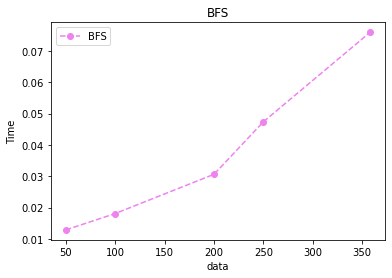

In [115]:
pylab.xlabel('data')
pylab.ylabel('Time')

plt.title("BFS")
plt.plot(x, test_bfs, "ro--",c="violet")
plt.legend(["BFS"], loc='upper left')
plt.show()

### DFS time complexity

In [116]:
start_time = time()
for i in ran_num:
    dfs(graph, 'ABY', i)
    end_time = time()
elapsed1 = end_time - start_time

start_time = time()
for i in ran_num2:
    dfs(graph, 'ABY', i)
end_time = time()
elapsed2 = end_time - start_time

start_time = time()
for i in ran_num3:
    dfs(graph, 'ABY', i)
end_time = time()
elapsed3 = end_time - start_time

start_time = time()
for i in ran_num4:
    dfs(graph, 'ABY', i)
end_time = time()
elapsed4 = end_time - start_time

start_time = time()
for i in ran_num5:
    dfs(graph, 'ABY', i)
end_time = time()
elapsed5 = end_time - start_time


In [117]:
x = [50, 100, 200, 250, 358]
test_dfs = []

test_dfs.append(elapsed1)
test_dfs.append(elapsed2)
test_dfs.append(elapsed3)
test_dfs.append(elapsed4)
test_dfs.append(elapsed5)

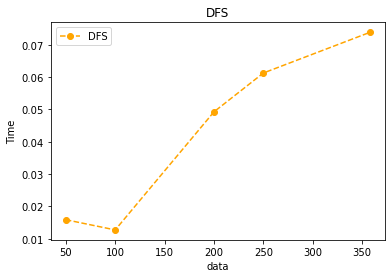

In [118]:
pylab.xlabel('data')
pylab.ylabel('Time')

plt.title("DFS")
plt.plot(x, test_dfs, "ro--",c="orange")
plt.legend(["DFS"], loc='upper left')
plt.show()

### BFS vs DFS

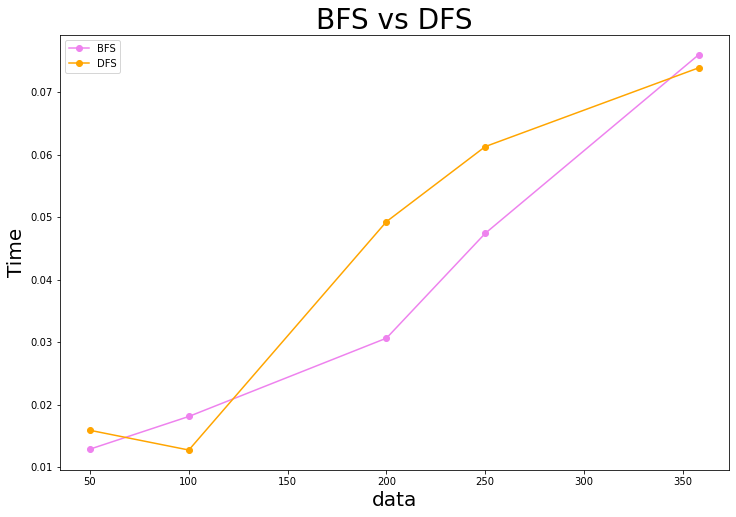

In [119]:
plt.figure(figsize=(12,8))
pylab.xlabel('data', fontsize=20)
pylab.ylabel('Time', fontsize=20)

plt.title("BFS vs DFS", fontsize=28)
plt.plot(x, test_bfs, "ro-", c="violet")
plt.plot(x, test_dfs, "ro-",c="orange")
plt.legend(["BFS", "DFS"], loc='upper left')
plt.show()

### Dijkstra time complexity

In [37]:
start_time = time()
for i in ran_num:
    dijkstra(gh, 'ABY', i)
end_time = time()
elapsed1 = end_time - start_time

start_time = time()
for i in ran_num2:
    dijkstra(gh, 'ABY', i)  
end_time = time()
elapsed2 = end_time - start_time

start_time = time()
for i in ran_num3:
    dijkstra(gh, 'ABY', i)  
end_time = time()
elapsed3 = end_time - start_time

start_time = time()
for i in ran_num4:
    dijkstra(gh, 'ABY', i)  
end_time = time()
elapsed4 = end_time - start_time

start_time = time()
for i in ran_num5:
    dijkstra(gh, 'ABY', i)  
end_time = time()
elapsed5 = end_time - start_time

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'ABE'] 

Distance when using Dijkstra: 
 1348 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DFW', 'ABI'] 

Distance when using Dijkstra: 
 1662 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'ABQ'] 

Distance when using Dijkstra: 
 2273 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'MSP', 'ABR'] 

Distance when using Dijkstra: 
 2107 km

Shortest path when using Dijkstra: 
 ['ABY'] 

Distance when using Dijkstra: 
 0 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'CLT', 'ACK'] 

Distance when using Dijkstra: 
 1761 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DFW', 'ACT'] 

Distance when using Dijkstra: 
 1553 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'SFO', 'ACV'] 

Distance when using Dijkstra: 
 4071 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'ACY'] 

Distance when using Dijkstra: 
 1326 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'ANC', 'ADK'

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'MSP', 'BIS'] 

Distance when using Dijkstra: 
 2314 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'MSP', 'BJI'] 

Distance when using Dijkstra: 
 2015 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DEN', 'BKG'] 

Distance when using Dijkstra: 
 3229 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DEN', 'BLI'] 

Distance when using Dijkstra: 
 3888 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'VPS', 'BLV'] 

Distance when using Dijkstra: 
 1583 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'BMI'] 

Distance when using Dijkstra: 
 1093 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'BNA'] 

Distance when using Dijkstra: 
 579 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DEN', 'BOI'] 

Distance when using Dijkstra: 
 3203 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'BOS'] 

Distance when using Dijkstra: 
 1756 km

Shortest path when using Dijkstra: 
 ['AB

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DEN', 'ASE'] 

Distance when using Dijkstra: 
 2362 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL'] 

Distance when using Dijkstra: 
 234 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'ATW'] 

Distance when using Dijkstra: 
 1467 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'AUS'] 

Distance when using Dijkstra: 
 1540 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'AVL'] 

Distance when using Dijkstra: 
 499 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'AVP'] 

Distance when using Dijkstra: 
 1384 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'SGF', 'AZA'] 

Distance when using Dijkstra: 
 2851 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DTW', 'AZO'] 

Distance when using Dijkstra: 
 1374 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'BDL'] 

Distance when using Dijkstra: 
 1616 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'ANC', 'BET'] 

Di

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'ANC', 'DUT'] 

Distance when using Dijkstra: 
 6993 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DEN', 'DVL'] 

Distance when using Dijkstra: 
 3187 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'SEA', 'EAT'] 

Distance when using Dijkstra: 
 3898 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'ORD', 'EAU'] 

Distance when using Dijkstra: 
 1643 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'ECP'] 

Distance when using Dijkstra: 
 621 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DEN', 'EGE'] 

Distance when using Dijkstra: 
 2355 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'SLC', 'EKO'] 

Distance when using Dijkstra: 
 3109 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'EWR', 'ELM'] 

Distance when using Dijkstra: 
 1713 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'ELP'] 

Distance when using Dijkstra: 
 2294 km

Shortest path when using Dijkstra:

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DEN', 'JMS'] 

Distance when using Dijkstra: 
 3084 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'SEA', 'JNU'] 

Distance when using Dijkstra: 
 5200 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'SAN', 'KOA'] 

Distance when using Dijkstra: 
 7380 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'SEA', 'KTN'] 

Distance when using Dijkstra: 
 4832 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DTW', 'LAN'] 

Distance when using Dijkstra: 
 1312 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DEN', 'LAR'] 

Distance when using Dijkstra: 
 2343 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'LAS'] 

Distance when using Dijkstra: 
 3039 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DFW', 'LAW'] 

Distance when using Dijkstra: 
 1634 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'LAX'] 

Distance when using Dijkstra: 
 3360 km

Shortest path when using Dijkstra

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'SEA', 'JNU', 'YAK', 'CDV'] 

Distance when using Dijkstra: 
 5860 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'ORD', 'CGI'] 

Distance when using Dijkstra: 
 1758 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'CHA'] 

Distance when using Dijkstra: 
 405 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'CHO'] 

Distance when using Dijkstra: 
 969 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'CHS'] 

Distance when using Dijkstra: 
 650 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'CID'] 

Distance when using Dijkstra: 
 1352 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DTW', 'CIU'] 

Distance when using Dijkstra: 
 1650 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'IAD', 'CKB'] 

Distance when using Dijkstra: 
 1336 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'CLE'] 

Distance when using Dijkstra: 
 1128 km

Shortest path when using Dijkstra: 
 ['ABY'

 ['ABY', 'ATL', 'DEN', 'GUC'] 

Distance when using Dijkstra: 
 2405 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DEN', 'HDN'] 

Distance when using Dijkstra: 
 2388 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'GSP', 'SFB', 'HGR'] 

Distance when using Dijkstra: 
 2425 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'CLT', 'HHH'] 

Distance when using Dijkstra: 
 932 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'MSP', 'HIB'] 

Distance when using Dijkstra: 
 1974 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DEN', 'HLN'] 

Distance when using Dijkstra: 
 3116 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'HNL'] 

Distance when using Dijkstra: 
 7468 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'IAH', 'HOB'] 

Distance when using Dijkstra: 
 2148 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'HOU'] 

Distance when using Dijkstra: 
 1353 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'HPN'] 

Di

 ['ABY', 'ATL', 'HNL', 'MKK'] 

Distance when using Dijkstra: 
 7556 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'MLB'] 

Distance when using Dijkstra: 
 948 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'MLI'] 

Distance when using Dijkstra: 
 1254 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'MLU'] 

Distance when using Dijkstra: 
 954 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'LAX', 'MMH'] 

Distance when using Dijkstra: 
 3771 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'MOB'] 

Distance when using Dijkstra: 
 720 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'MSP', 'MOT'] 

Distance when using Dijkstra: 
 2415 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'ORD', 'MQT'] 

Distance when using Dijkstra: 
 1699 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'LAS', 'MRY'] 

Distance when using Dijkstra: 
 3641 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'MSN'] 

Distance when using Dijks

 ['ABY', 'ATL', 'ORD', 'CWA'] 

Distance when using Dijkstra: 
 1553 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DAB'] 

Distance when using Dijkstra: 
 824 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DAL'] 

Distance when using Dijkstra: 
 1392 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DAY'] 

Distance when using Dijkstra: 
 931 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'ORD', 'DBQ'] 

Distance when using Dijkstra: 
 1447 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DCA'] 

Distance when using Dijkstra: 
 1115 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DEN'] 

Distance when using Dijkstra: 
 2161 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DFW'] 

Distance when using Dijkstra: 
 1409 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DHN'] 

Distance when using Dijkstra: 
 509 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DEN', 'DIK'] 

Distance when using Dijkstra: 
 2947 km

 ['ABY', 'ATL', 'DEN', 'IDA'] 

Distance when using Dijkstra: 
 2897 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'ILM'] 

Distance when using Dijkstra: 
 840 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DTW', 'IMT'] 

Distance when using Dijkstra: 
 1745 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'IND'] 

Distance when using Dijkstra: 
 931 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'MSP', 'INL'] 

Distance when using Dijkstra: 
 2104 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'PHL', 'IPT'] 

Distance when using Dijkstra: 
 1514 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'MSP', 'ISN'] 

Distance when using Dijkstra: 
 2571 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'ISP'] 

Distance when using Dijkstra: 
 1513 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'PHL', 'ITH'] 

Distance when using Dijkstra: 
 1615 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'LAX', 'ITO'] 

Distance w

 ['ABY', 'ATL', 'OMA'] 

Distance when using Dijkstra: 
 1555 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'ANC', 'OME'] 

Distance when using Dijkstra: 
 6587 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'PHX', 'ONT'] 

Distance when using Dijkstra: 
 3305 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'ORD'] 

Distance when using Dijkstra: 
 1211 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'ORF'] 

Distance when using Dijkstra: 
 1064 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'JFK', 'ORH'] 

Distance when using Dijkstra: 
 1697 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DEN', 'OTH'] 

Distance when using Dijkstra: 
 3831 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'ANC', 'OTZ'] 

Distance when using Dijkstra: 
 6603 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'GSP', 'SFB', 'OWB'] 

Distance when using Dijkstra: 
 2306 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'ORD', 'PAH'] 

D

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DEN', 'SUN'] 

Distance when using Dijkstra: 
 3056 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'ORD', 'SUX'] 

Distance when using Dijkstra: 
 1910 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'PHL', 'SWF'] 

Distance when using Dijkstra: 
 1511 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'DFW', 'SWO'] 

Distance when using Dijkstra: 
 1772 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'SYR'] 

Distance when using Dijkstra: 
 1512 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'TLH'] 

Distance when using Dijkstra: 
 595 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'CLT', 'TOL'] 

Distance when using Dijkstra: 
 1350 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'TPA'] 

Distance when using Dijkstra: 
 889 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL', 'TRI'] 

Distance when using Dijkstra: 
 600 km

Shortest path when using Dijkstra: 
 ['ABY', 'ATL'

In [38]:
x = [50, 100, 200, 250, 358]
test_dijk = []

test_dijk.append(elapsed1)
test_dijk.append(elapsed2)
test_dijk.append(elapsed3)
test_dijk.append(elapsed4)
test_dijk.append(elapsed5)

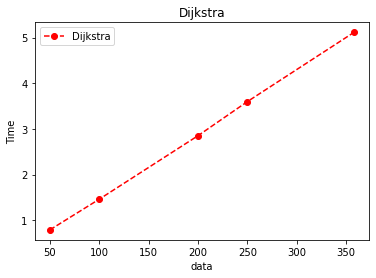

In [39]:
pylab.xlabel('data')
pylab.ylabel('Time')

plt.title("Dijkstra")
plt.plot(x, test_dijk, "ro--",c="red")
plt.legend(["Dijkstra"], loc='upper left')
plt.show()

### Advanced Dijkstra time complexity

In [40]:
start_time = time()
for i in ran_num:
    dijkstra_heapq(dict1, 'ABY', i)  
end_time = time()
elapsed1 = end_time - start_time

start_time = time()
for i in ran_num2:
    dijkstra_heapq(dict1, 'ABY', i)  
end_time = time()
elapsed2 = end_time - start_time

start_time = time()
for i in ran_num3:
    dijkstra_heapq(dict1, 'ABY', i)  
end_time = time()
elapsed3 = end_time - start_time

start_time = time()
for i in ran_num4:
    dijkstra_heapq(dict1, 'ABY', i)  
end_time = time()
elapsed4 = end_time - start_time

start_time = time()
for i in ran_num5:
    dijkstra_heapq(dict1, 'ABY', i)  
end_time = time()
elapsed5 = end_time - start_time

Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'ABE'] 

Distance when using Dijkstra with heapq: 
 1348 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'DFW', 'ABI'] 

Distance when using Dijkstra with heapq: 
 1662 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'ABQ'] 

Distance when using Dijkstra with heapq: 
 2273 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'MSP', 'ABR'] 

Distance when using Dijkstra with heapq: 
 2107 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ABY'] 

Distance when using Dijkstra with heapq: 
 0 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'CLT', 'ACK'] 

Distance when using Dijkstra with heapq: 
 1761 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'DFW', 'ACT'] 

Distance when using Dijkstra with heapq: 
 1553 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'SFO', 'ACV'] 

Distance when using Dijkstra with heapq: 


 ['ABY', 'ATL', 'IAD', 'CKB'] 

Distance when using Dijkstra with heapq: 
 1336 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'CLE'] 

Distance when using Dijkstra with heapq: 
 1128 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'IAH', 'CLL'] 

Distance when using Dijkstra with heapq: 
 1461 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'CLT'] 

Distance when using Dijkstra with heapq: 
 599 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'CMH'] 

Distance when using Dijkstra with heapq: 
 955 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'ORD', 'CMI'] 

Distance when using Dijkstra with heapq: 
 1429 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'ORD', 'CMX'] 

Distance when using Dijkstra with heapq: 
 1790 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'DEN', 'CNY'] 

Distance when using Dijkstra with heapq: 
 2615 km
Shortest path when using Dijks

 ['ABY', 'ATL', 'HOU', 'CRP'] 

Distance when using Dijkstra with heapq: 
 1653 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'CRW'] 

Distance when using Dijkstra with heapq: 
 820 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'CSG'] 

Distance when using Dijkstra with heapq: 
 368 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'CVG'] 

Distance when using Dijkstra with heapq: 
 837 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'ORD', 'CWA'] 

Distance when using Dijkstra with heapq: 
 1553 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'DAB'] 

Distance when using Dijkstra with heapq: 
 824 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'DAL'] 

Distance when using Dijkstra with heapq: 
 1392 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'DAY'] 

Distance when using Dijkstra with heapq: 
 931 km
Shortest path when using Dijkstra with heapq: 
 ['ABY'

 ['ABY', 'ATL', 'LGA'] 

Distance when using Dijkstra with heapq: 
 1459 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'PHX', 'LGB'] 

Distance when using Dijkstra with heapq: 
 3353 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'LAX', 'LIH'] 

Distance when using Dijkstra with heapq: 
 7563 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'ABE'] 

Distance when using Dijkstra with heapq: 
 1348 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'DFW', 'ABI'] 

Distance when using Dijkstra with heapq: 
 1662 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'ABQ'] 

Distance when using Dijkstra with heapq: 
 2273 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'MSP', 'ABR'] 

Distance when using Dijkstra with heapq: 
 2107 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ABY'] 

Distance when using Dijkstra with heapq: 
 0 km
Shortest path when using Dijkstra with heapq:

 ['ABY', 'ATL', 'CID'] 

Distance when using Dijkstra with heapq: 
 1352 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'DTW', 'CIU'] 

Distance when using Dijkstra with heapq: 
 1650 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'IAD', 'CKB'] 

Distance when using Dijkstra with heapq: 
 1336 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'CLE'] 

Distance when using Dijkstra with heapq: 
 1128 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'IAH', 'CLL'] 

Distance when using Dijkstra with heapq: 
 1461 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'CLT'] 

Distance when using Dijkstra with heapq: 
 599 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'CMH'] 

Distance when using Dijkstra with heapq: 
 955 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'ORD', 'CMI'] 

Distance when using Dijkstra with heapq: 
 1429 km
Shortest path when using Dijkstra wit

 ['ABY', 'ATL', 'IAH'] 

Distance when using Dijkstra with heapq: 
 1342 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'ICT'] 

Distance when using Dijkstra with heapq: 
 1490 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'DEN', 'IDA'] 

Distance when using Dijkstra with heapq: 
 2897 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'ILM'] 

Distance when using Dijkstra with heapq: 
 840 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'DTW', 'IMT'] 

Distance when using Dijkstra with heapq: 
 1745 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'IND'] 

Distance when using Dijkstra with heapq: 
 931 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'MSP', 'INL'] 

Distance when using Dijkstra with heapq: 
 2104 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'PHL', 'IPT'] 

Distance when using Dijkstra with heapq: 
 1514 km
Shortest path when using Dijkstra wit

 ['ABY', 'ATL', 'ABQ'] 

Distance when using Dijkstra with heapq: 
 2273 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'MSP', 'ABR'] 

Distance when using Dijkstra with heapq: 
 2107 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ABY'] 

Distance when using Dijkstra with heapq: 
 0 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'CLT', 'ACK'] 

Distance when using Dijkstra with heapq: 
 1761 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'DFW', 'ACT'] 

Distance when using Dijkstra with heapq: 
 1553 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'SFO', 'ACV'] 

Distance when using Dijkstra with heapq: 
 4071 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'ACY'] 

Distance when using Dijkstra with heapq: 
 1326 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'ANC', 'ADK'] 

Distance when using Dijkstra with heapq: 
 7636 km
Shortest path when using Dijkstra with

 1193 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'ANC', 'DUT'] 

Distance when using Dijkstra with heapq: 
 6993 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'DEN', 'JMS', 'DVL'] 

Distance when using Dijkstra with heapq: 
 3216 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'SEA', 'EAT'] 

Distance when using Dijkstra with heapq: 
 3898 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'ORD', 'EAU'] 

Distance when using Dijkstra with heapq: 
 1643 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'ECP'] 

Distance when using Dijkstra with heapq: 
 621 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'DEN', 'EGE'] 

Distance when using Dijkstra with heapq: 
 2355 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'SLC', 'EKO'] 

Distance when using Dijkstra with heapq: 
 3109 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'EWR', 'ELM'] 

Dis

 ['ABY', 'ATL', 'LFT'] 

Distance when using Dijkstra with heapq: 
 1043 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'LGA'] 

Distance when using Dijkstra with heapq: 
 1459 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'PHX', 'LGB'] 

Distance when using Dijkstra with heapq: 
 3353 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'LAX', 'LIH'] 

Distance when using Dijkstra with heapq: 
 7563 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'LIT'] 

Distance when using Dijkstra with heapq: 
 962 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'LNK'] 

Distance when using Dijkstra with heapq: 
 1587 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'HNL', 'LNY'] 

Distance when using Dijkstra with heapq: 
 7586 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'IAH', 'LRD'] 

Distance when using Dijkstra with heapq: 
 1827 km
Shortest path when using Dijkstra wi

 ['ABY', 'ATL', 'SHV'] 

Distance when using Dijkstra with heapq: 
 1120 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'SEA', 'SIT'] 

Distance when using Dijkstra with heapq: 
 5123 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'SJC'] 

Distance when using Dijkstra with heapq: 
 3632 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'DFW', 'SJT'] 

Distance when using Dijkstra with heapq: 
 1777 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'SLC'] 

Distance when using Dijkstra with heapq: 
 2788 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'ICT', 'HYS', 'SLN'] 

Distance when using Dijkstra with heapq: 
 1839 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'SMF'] 

Distance when using Dijkstra with heapq: 
 3594 km
Shortest path when using Dijkstra with heapq: 
 ['ABY', 'ATL', 'LAS', 'SMX'] 

Distance when using Dijkstra with heapq: 
 3537 km
Shortest path when using Dij

In [41]:
x = [50, 100, 200, 250, 358]
testdijkstra_2 = []

testdijkstra_2.append(elapsed1)
testdijkstra_2.append(elapsed2)
testdijkstra_2.append(elapsed3)
testdijkstra_2.append(elapsed4)
testdijkstra_2.append(elapsed5)

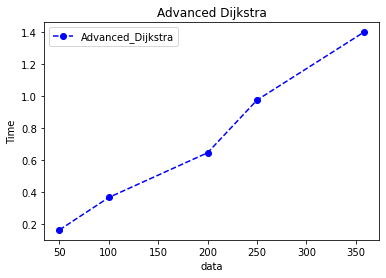

In [42]:
pylab.xlabel('data')
pylab.ylabel('Time')

plt.title("Advanced Dijkstra")
plt.plot(x, testdijkstra_2, "ro--",c="blue")
plt.legend(["Advanced_Dijkstra"], loc='upper left')
plt.show()

### Dijkstra vs Advanced Dijkstra

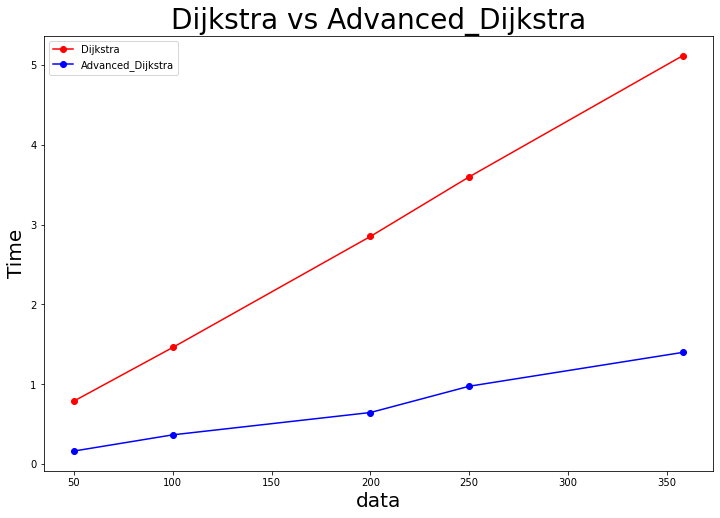

In [43]:
plt.figure(figsize=(12,8))
pylab.xlabel('data', fontsize=20)
pylab.ylabel('Time', fontsize=20)

plt.title("Dijkstra vs Advanced_Dijkstra", fontsize=28)
plt.plot(x, test_dijk, "ro-",c="red")
plt.plot(x, testdijkstra_2, "ro-",c="blue")
plt.legend(["Dijkstra", "Advanced_Dijkstra"], loc='upper left')
plt.show()

### BFS vs DFS vs Dijkstra vs Advanced Dijkstra

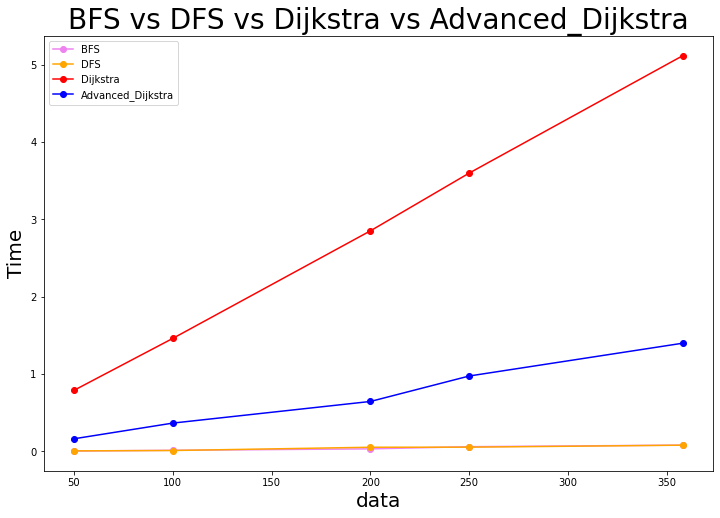

In [44]:
plt.figure(figsize=(12,8))
pylab.xlabel('data', fontsize=20)
pylab.ylabel('Time', fontsize=20)

plt.title("BFS vs DFS vs Dijkstra vs Advanced_Dijkstra", fontsize=28)
plt.plot(x, test_bfs, "ro-", c="violet")
plt.plot(x, test_dfs, "ro-",c="orange")
plt.plot(x, test_dijk, "ro-",c="red")
plt.plot(x, testdijkstra_2, "ro-",c="blue")
plt.legend(["BFS", "DFS", "Dijkstra", "Advanced_Dijkstra"], loc='upper left')
plt.show()